<a href="https://colab.research.google.com/github/ajk251/CS5200-Project/blob/main/TensorFlow%20Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Neural Style Transfer**

This code is based on the example from the TensorFlow documentation, https://www.tensorflow.org/tutorials/generative/style_transfer.

In [157]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools


np.set_printoptions(precision=3)

In [158]:
# Helper functions to load, processes, and display images. Transforms images
#  to tensors in the  proper format

def tensor_to_image(tensor):
  
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

  return PIL.Image.fromarray(tensor)


def load_img(path_to_img):

  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]

  return img


def imshow(image, title=None):

  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  
  if title:
    plt.title(title)


**Content Images**

1024px-Shinjuku_Gyoen_National_Garden_and_NTT_DoCoMo_Yoyogi_Building,_Tokyo,_Japan.jpg

https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Shinjuku_Gyoen_National_Garden_and_NTT_DoCoMo_Yoyogi_Building%2C_Tokyo%2C_Japan.jpg/1024px-Shinjuku_Gyoen_National_Garden_and_NTT_DoCoMo_Yoyogi_Building%2C_Tokyo%2C_Japan.jpg


800px-IMG-20190123-WA0044.jpg

https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/IMG-20190123-WA0044.jpg/800px-IMG-20190123-WA0044.jpg


800px-Landscape_Arnisee-region.JPG

https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Landscape_Arnisee-region.JPG/800px-Landscape_Arnisee-region.JPG



800px-Landscape_Arnisee-region.JPG

https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Landscape_Arnisee-region.JPG/800px-Landscape_Arnisee-region.JPG


800px-Hortus_Botanicus_Amsterdam._(actm.).jpg

https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/Hortus_Botanicus_Amsterdam._%28actm.%29.jpg/800px-Hortus_Botanicus_Amsterdam._%28actm.%29.jpg


800px-KeizersgrachtReguliersgrachtAmsterdam.jpg

https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/KeizersgrachtReguliersgrachtAmsterdam.jpg/800px-KeizersgrachtReguliersgrachtAmsterdam.jpg



800px-Amsterdam_2016.jpg

https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Amsterdam_2016.jpg/800px-Amsterdam_2016.jpg


New_Amsterdam_benchmark.jpg

https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/New_Amsterdam_benchmark.jpg/800px-New_Amsterdam_benchmark.jpg

** Style Images **

800px-Amedeo_Modigliani_-_Portrait_of_Juan_Gris.jpg

https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Amedeo_Modigliani_-_Portrait_of_Juan_Gris.jpg/800px-Amedeo_Modigliani_-_Portrait_of_Juan_Gris.jpg


Eamon_Everall._Candy_Stripes.jpg

https://upload.wikimedia.org/wikipedia/commons/1/1e/Eamon_Everall._Candy_Stripes.jpg



Jan_Matulka_-_Tŭri_Pôle_Landscape_(c1921).jpg

https://upload.wikimedia.org/wikipedia/commons/6/67/Jan_Matulka_-_T%C5%ADri_P%C3%B4le_Landscape_%28c1921%29.jpg


800px-JuanGris.Portrait_of_Picasso.jpg

https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/JuanGris.Portrait_of_Picasso.jpg/800px-JuanGris.Portrait_of_Picasso.jpg


800px-"Joy_-_Collage_of_Life"_,_René_Cheng,_oil_painting,_2017.jpg

https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/%22Joy_-_Collage_of_Life%22_%2C_Ren%C3%A9_Cheng%2C_oil_painting%2C_2017.jpg/800px-%22Joy_-_Collage_of_Life%22_%2C_Ren%C3%A9_Cheng%2C_oil_painting%2C_2017.jpg



landscape-at-lestaque-1024x859.jpg

https://noma.org/wp-content/uploads/2015/08/landscape-at-lestaque-1024x859.jpg


"L'avantage_des_voyages"_ou_"Le_Marin"_-_75_GAÏTIS.jpg
https://upload.wikimedia.org/wikipedia/commons/9/90/%22L%27avantage_des_voyages%22_ou_%22Le_Marin%22_-_75_GA%C3%8FTIS.jpg



800px-1860_Intro-_Nigel_Packhams_140x170cm_1997_Gemälde

https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/1860_Intro-_Nigel_Packhams_140x170cm_1997_Gem%C3%A4lde.jpg/800px-1860_Intro-_Nigel_Packhams_140x170cm_1997_Gem%C3%A4lde.jpg


Alaa-Awad-painting-05.jpg

https://upload.wikimedia.org/wikipedia/commons/7/7c/Alaa-Awad-painting-05.jpg

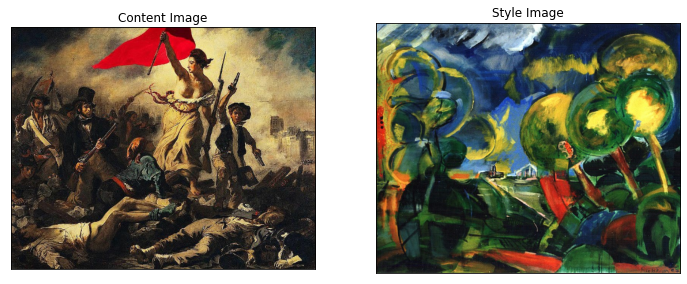

<Figure size 864x864 with 0 Axes>

In [159]:

# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

# content_path = tf.keras.utils.get_file('1024px-Old_house_typical_of_the_island_of_Margarita.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Old_house_typical_of_the_island_of_Margarita.jpg/1024px-Old_house_typical_of_the_island_of_Margarita.jpg')
# style_path = tf.keras.utils.get_file('6ad8f7d6-c8a9-5216-2664-09bd5691c6ed.jpg','https://www.artic.edu/iiif/2/6ad8f7d6-c8a9-5216-2664-09bd5691c6ed/full/843,/0/default.jpg')

# content_path = tf.keras.utils.get_file('Chicago Union Station 1943.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Chicago_Union_Station_1943.jpg/600px-Chicago_Union_Station_1943.jpg')
# style_path = tf.keras.utils.get_file('6ad8f7d6-c8a9-5216-2664-09bd5691c6ed.jpg','https://www.artic.edu/iiif/2/6ad8f7d6-c8a9-5216-2664-09bd5691c6ed/full/843,/0/default.jpg')

# content_path = tf.keras.utils.get_file('800px-Betsy_DeVos_official_portrait.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Betsy_DeVos_official_portrait.jpg/800px-Betsy_DeVos_official_portrait.jpg')
# style_path = tf.keras.utils.get_file('800px-Quentin_Matsys_-_A_Grotesque_old_woman.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Quentin_Matsys_-_A_Grotesque_old_woman.jpg/800px-Quentin_Matsys_-_A_Grotesque_old_woman.jpg')

# content_path = tf.keras.utils.get_file('American_Gothic_Dress-Up.jpg', 'https://upload.wikimedia.org/wikipedia/commons/b/bb/American_Gothic_Dress-Up.jpg')
# style_path = tf.keras.utils.get_file('Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg/497px-Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg')

# content_path = tf.keras.utils.get_file('800px-Paradise_shelduck_portrait,_New_Zealand.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Paradise_shelduck_portrait%2C_New_Zealand.jpg/800px-Paradise_shelduck_portrait%2C_New_Zealand.jpg')
# style_path = tf.keras.utils.get_file('800px-Red-billed_gull_portrait,_New_Brighton,_New_Zealand_03','https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Red-billed_gull_portrait%2C_New_Brighton%2C_New_Zealand_03.jpg/800px-Red-billed_gull_portrait%2C_New_Brighton%2C_New_Zealand_03.jpg')

# style_path = tf.keras.utils.get_file('800px-1993._Particule_en_mouvement_gauche_droite,huile_sur_bois,_65x50_cm.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/1993._Particule_en_mouvement_gauche_droite%2Chuile_sur_bois%2C_65x50_cm.jpg/800px-1993._Particule_en_mouvement_gauche_droite%2Chuile_sur_bois%2C_65x50_cm.jpg')
# style_path = tf.keras.utils.get_file('Agamemnon"_-_107_GAÏTIS.jpg','https://upload.wikimedia.org/wikipedia/commons/8/8f/%22Agamemnon%22_-_107_GA%C3%8FTIS.jpg')

# content_path = tf.keras.utils.get_file('800px-Green_Sea_Turtle_grazing_seagrass.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg/800px-Green_Sea_Turtle_grazing_seagrass.jpg')
# style_path = tf.keras.utils.get_file('Tsunami_by_hokusai_19th_century.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/800px-Tsunami_by_hokusai_19th_century.jpg')

# content_path = tf.keras.utils.get_file('1024px-Shinjuku_Gyoen_National_Garden_and_NTT_DoCoMo_Yoyogi_Building,_Tokyo,_Japan.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Shinjuku_Gyoen_National_Garden_and_NTT_DoCoMo_Yoyogi_Building%2C_Tokyo%2C_Japan.jpg/1024px-Shinjuku_Gyoen_National_Garden_and_NTT_DoCoMo_Yoyogi_Building%2C_Tokyo%2C_Japan.jpg')
# style_path = tf.keras.utils.get_file('Jan_Matulka_-Tŭri_Pôle_Landscape(c1921).jpg','https://upload.wikimedia.org/wikipedia/commons/6/67/Jan_Matulka_-_T%C5%ADri_P%C3%B4le_Landscape_%28c1921%29.jpg')

# style_path = tf.keras.utils.get_file('800px-"Joy_-Collage_of_Life",_René_Cheng,_oil_painting,_2017.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/%22Joy_-_Collage_of_Life%22_%2C_Ren%C3%A9_Cheng%2C_oil_painting%2C_2017.jpg/800px-%22Joy_-_Collage_of_Life%22_%2C_Ren%C3%A9_Cheng%2C_oil_painting%2C_2017.jpg')

# content_path = tf.keras.utils.get_file('1024px-Shinjuku_Gyoen_National_Garden_and_NTT_DoCoMo_Yoyogi_Building,_Tokyo,_Japan.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Shinjuku_Gyoen_National_Garden_and_NTT_DoCoMo_Yoyogi_Building%2C_Tokyo%2C_Japan.jpg/1024px-Shinjuku_Gyoen_National_Garden_and_NTT_DoCoMo_Yoyogi_Building%2C_Tokyo%2C_Japan.jpg')
# style_path = tf.keras.utils.get_file('landscape-at-lestaque-1024x859.jpg','https://noma.org/wp-content/uploads/2015/08/landscape-at-lestaque-1024x859.jpg')

style_path = tf.keras.utils.get_file('800px-1860_Intro-_Nigel_Packhams_140x170cm_1997_Gemälde','https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/1860_Intro-_Nigel_Packhams_140x170cm_1997_Gem%C3%A4lde.jpg/800px-1860_Intro-_Nigel_Packhams_140x170cm_1997_Gem%C3%A4lde.jpg')
# content_path = tf.keras.utils.get_file('800px-Landscape_Arnisee-region.JPG', 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Landscape_Arnisee-region.JPG/800px-Landscape_Arnisee-region.JPG')

content_path = tf.keras.utils.get_file('New_Amsterdam_benchmark.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/New_Amsterdam_benchmark.jpg/800px-New_Amsterdam_benchmark.jpg')
# style_path = tf.keras.utils.get_file('Alaa-Awad-painting-05.jpg','https://upload.wikimedia.org/wikipedia/commons/7/7c/Alaa-Awad-painting-05.jpg')



content_image = load_img(content_path)
style_image = load_img(style_path)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Content Image')
ax1.imshow(tf.squeeze(content_image, axis=0))

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Style Image')
ax2.imshow(tf.squeeze(style_image, axis=0))

plt.show()
plt.savefig('Content and Style Images.jpg', quality=95);

In [160]:
# Load VGG-19 model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print([layer.name for layer in vgg.layers])

['input_22', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


# Building the model

In [161]:
# These layer are the intermediate layers that represent the style and content
#   of the image

content_layers = ['block5_conv2', 'block5_conv4'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1',
                'block5_conv4']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

print('Number of content layers: ', num_content_layers)
print('Number of style layers:   ', num_style_layers)


Number of content layers:  2
Number of style layers:    6


In [162]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)

  return model

def gram_matrix(input_tensor):

  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  
  return result/(num_locations)
    

class StyleContentModel(tf.keras.models.Model):

  def __init__(self, style_layers, content_layers):

    super(StyleContentModel, self).__init__()

    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)

    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


In [163]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()


block1_conv1
  shape:  (1, 421, 512, 64)
  min:  0.0
  max:  847.68616
  mean:  21.288666

block2_conv1
  shape:  (1, 210, 256, 128)
  min:  0.0
  max:  3897.7175
  mean:  121.26189

block3_conv1
  shape:  (1, 105, 128, 256)
  min:  0.0
  max:  7951.1035
  mean:  142.8117

block4_conv1
  shape:  (1, 52, 64, 512)
  min:  0.0
  max:  18879.46
  mean:  540.2719

block5_conv1
  shape:  (1, 26, 32, 512)
  min:  0.0
  max:  2257.4016
  mean:  45.18933

block5_conv4
  shape:  (1, 26, 32, 512)
  min:  0.0
  max:  206.63423
  mean:  1.3646458



In [164]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.026437948
    max:  25041.201
    mean:  633.7119

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  171289.52
    mean:  22238.799

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  485857.03
    mean:  21716.943

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  9950821.0
    mean:  362842.0

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  115051.22
    mean:  2688.1763

   block5_conv4
    shape:  (1, 512, 512)
    min:  0.0
    max:  546.63293
    mean:  2.5580742

Contents:
   block5_conv2
    shape:  (1, 25, 32, 512)
    min:  0.0
    max:  1490.0902
    mean:  20.420464
   block5_conv4
    shape:  (1, 25, 32, 512)
    min:  0.0
    max:  221.44269
    mean:  1.33844


In [165]:
def style_content_loss(outputs):

    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    
    # style_loss *= style_weight / num_style_layers
    style_loss *= np.array([0.05, 0.05, 0.25, 0.25, 0.4]) / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    
    content_loss *= content_weight / num_content_layers
    # content_loss *= np.array([0.75, 0.25]) / num_content_layers

    loss = style_loss + content_loss

    return loss

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


In [166]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4


In [167]:
@tf.function()
def train_step(image):
  
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


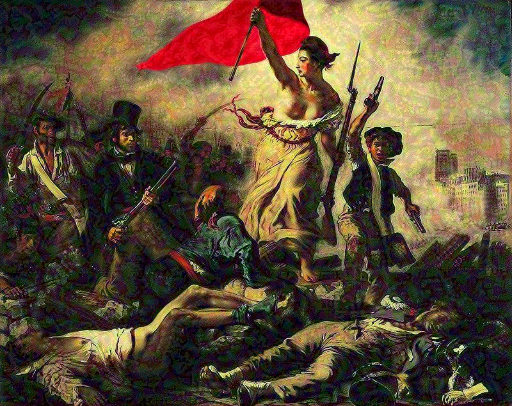

In [168]:
# test image with just 3 runs

train_step(image)
train_step(image)
train_step(image)

tensor_to_image(image)

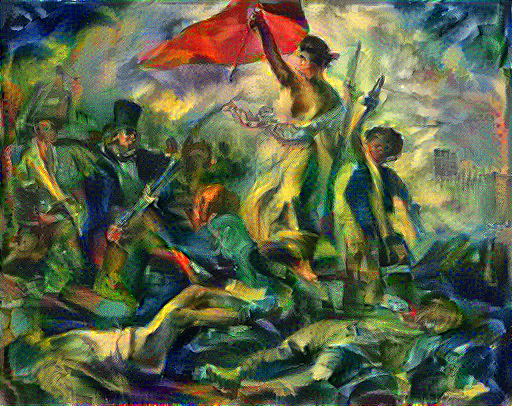

Train step: 1000
Total time: 82.3


In [169]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    
    step += 1
    train_step(image)
    print(".", end='')

  display.clear_output(wait=True)
  display.display(tensor_to_image(image))

  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [170]:
filename = 'image18.png'
tensor_to_image(image).save(filename)

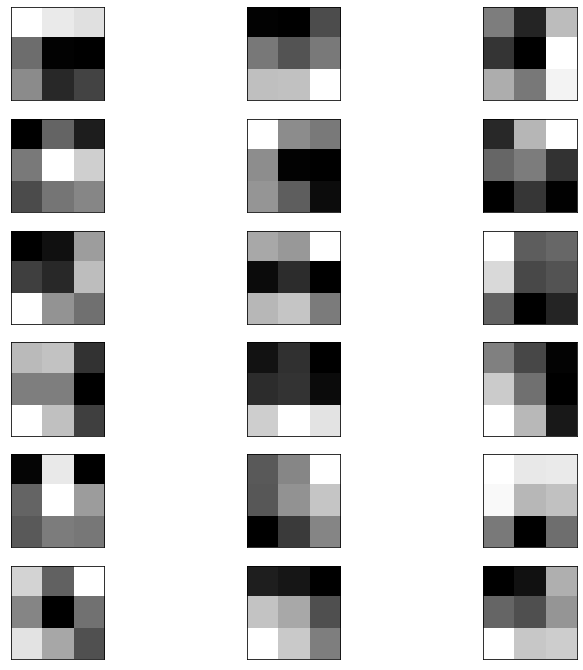

In [171]:
# Adapted from:
#   https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

# -3 is the 'block5_conv2' layer

filters, biases = vgg.layers[-3].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 6,1

for i in range(n_filters):
  f = filters[:,:,:,i]
  for j in range(3):

    ax = plt.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:,:,j], cmap='gray')
    ix += 1

plt.show()


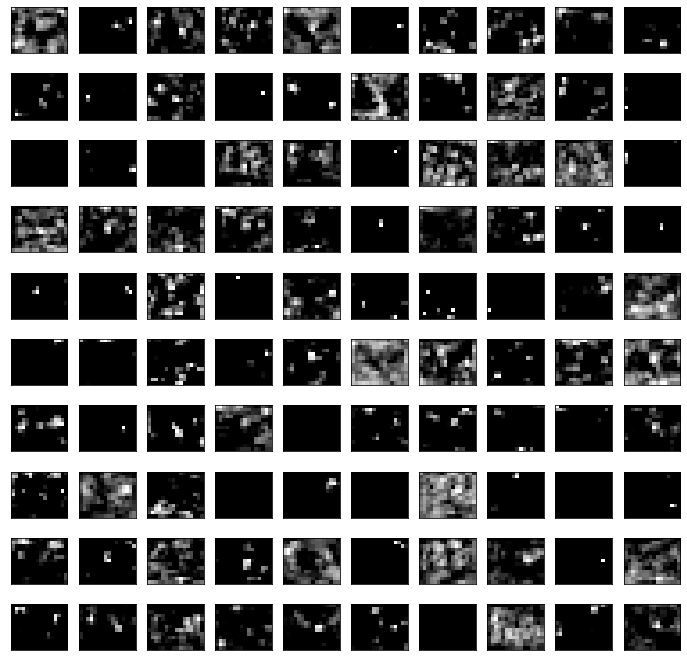

In [172]:
# Adapted from:
#   https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

# This is only showing a small selection 

feature_maps = vgg.predict(style_image)

square = 10
ix = 1

for _ in range(square):
  for _ in range(square):
    
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1

plt.show()

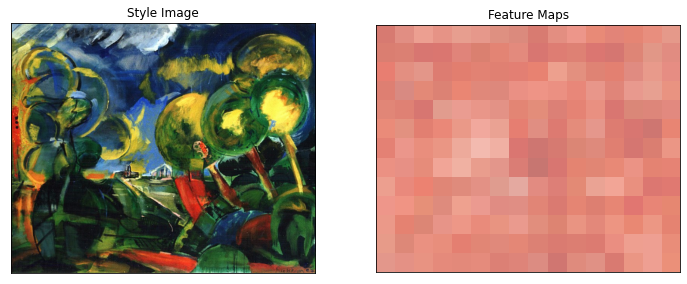

In [173]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Style Image')
ax1.imshow(tf.squeeze(style_image, axis=0))



ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Feature Maps')

for n in range(feature_maps.shape[3]):
  ax2.imshow(feature_maps[0, :, :, n], cmap='Reds', alpha=0.01)

# fig.colorbar()
plt.show();


In [174]:
# feature_maps[0, :, :, 23]

In [175]:
gram_matrix(style_image)

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[0.141, 0.132, 0.081],
        [0.132, 0.146, 0.097],
        [0.081, 0.097, 0.085]]], dtype=float32)>

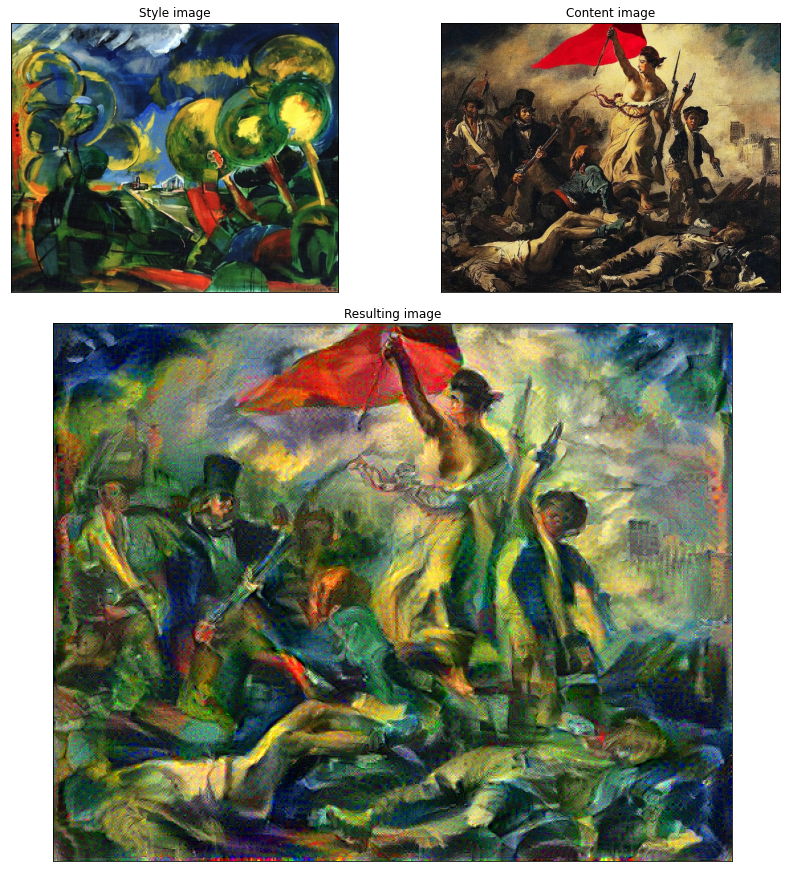

In [176]:
# https://stackoverflow.com/questions/37360568/python-organisation-of-3-subplots-with-matplotlib

import matplotlib.gridspec as gridspec

fig2 = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=3, figure=fig2)

ax1 = fig2.add_subplot(spec2[0, 0])
ax2 = fig2.add_subplot(spec2[0, 1])
ax3 = fig2.add_subplot(spec2[1:, :])

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Style image')
ax1.imshow(tf.squeeze(style_image, axis=0))

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Content image')
ax2.imshow(tf.squeeze(content_image, axis=0))

ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Resulting image')
ax3.imshow(tf.squeeze(image, axis=0));